In [127]:
using ForwardDiff, PreallocationTools, Interpolations, LinearAlgebra
using IterativeSolvers, LinearMaps, AlgebraicMultigrid
using BenchmarkTools, Plots

In [128]:
Float = Float64
nₓ = 4
nₜ = 1024
Δx = 2π / nₓ
# Δt = 0.02
Δt = Δx/2

x_bound = 2π - Δx
x_bound_stagg = x_bound + Δx/2
x_range = range(0, x_bound, nₓ)
x_stagg = range(Δx/2, x_bound_stagg, nₓ)
indices = CartesianIndices((1:nₓ, 1:nₓ, 1:nₓ))

# preallocations
u_arr = zeros(Float, 3 * nₓ^3)
u_new_arr = zeros(Float, 3 * nₓ^3)
coords_arr = zeros(Float, 3 * nₓ^3)
coords_new_arr = zeros(Float, 3 * nₓ^3)
# pressure = zeros(nₓ, nₓ, nₓ)


# These cache memory for the automatic differentiation
# and store references to the original allocation
u_arr_d = DiffCache(u_arr)
u_new_arr_d = DiffCache(u_new_arr)
coords_arr_d = DiffCache(coords_arr)
coords_new_arr_d = DiffCache(coords_new_arr)
# pressure_d = DiffCache(pressure)

# reshapes 1D array into vector of 3D arrays, with no allocation
function get_views(u)
    @views begin
        u_x = reshape(u[1:nₓ^3], (nₓ, nₓ, nₓ))
        u_y = reshape(u[nₓ^3+1:2*nₓ^3], (nₓ, nₓ, nₓ))
        u_z = reshape(u[2*nₓ^3+1:end], (nₓ, nₓ, nₓ))
    end
    return [u_x, u_y, u_z]
end

u = get_views(u_arr)
coords = get_views(coords_arr)

coords[1] .= [x for z ∈ x_range, y ∈ x_range, x ∈ x_range]
coords[2] .= [y for z ∈ x_range, y ∈ x_range, x ∈ x_range]
coords[3] .= [z for z ∈ x_range, y ∈ x_range, x ∈ x_range];

In [139]:
# some helpers for doing modulo arithmetic with CartesianIndex
Base.mod1(I::CartesianIndex, J::CartesianIndex) = CartesianIndex(broadcast(mod1, Tuple(I), Tuple(J)))
δ(I::CartesianIndex{N}, dim) where N = CartesianIndex(ntuple(i -> i == dim ? 1 : 0, N))

function interp_linear_periodic(x, y, z, F)
    bound = CartesianIndex(nₓ, nₓ, nₓ)
    # scale coordinates
    xs, ys, zs = x/Δx, y/Δx, z/Δx
    # get integer parts and remainders
    # that is, the origin vertex of the current grid cell,
    # and the relative coordinates from that vertex
    i, j, k = trunc.((xs, ys, zs))
    r, s, t = xs - i, ys - j, zs - k
    i, j, k = Int.([i, j, k] .+ 1)

    I = mod1(CartesianIndex(i, j, k), bound)
    I_ones = CartesianIndex(1, 1, 1)
    C = zeros(eltype(F), 2, 2, 2)
    for I_c in CartesianIndices(C)
        I_rel = I_c - I_ones
        C[I_c] = F[mod1(I + I_rel, bound)]
    end

    # interp over x, y, then z
    C = (1-r)*C[1,:,:] + r*C[2,:,:]
    C = (1-s)*C[1,:] + s*C[2,:]
    C = (1-t)*C[1] + t*C[2]
    return C
end

function TaylorGreen!(u)
    u_x, u_y, u_z = u
    x, y, z = coords
    @. u_x =  sin(x) * cos(y) * cos(z)
    @. u_y = -cos(x) * sin(y) * cos(z)
    @. u_z = 0.
    return
end

TaylorGreen!(u)
u_arr .+= 1e-2*randn(size(u_arr));

In [140]:
using SparseArrays

function ∂(A, dim;h=Δx)
    # This works for A of arbitrary dimension
    out = similar(A)
    R = CartesianIndices(A)
    bound = last(R)
    for I ∈ R
        I⁻ = mod1(I - δ(I, dim), bound)
        # second order
        I⁺ = mod1(I + δ(I, dim), bound)
        out[I] = 1/2h * (A[I⁺] - A[I⁻])
        # first order
        # out[I] = 1/h * (A[I] - A[I⁻])
    end
    return out
end

# divergence, curl, gradient, and laplacian
∇_dot(V) = sum(enumerate(V)) do (i, V_i)
    ∂(V_i, i)
end
function ∇X(V)
    out_arr = zeros(3*nₓ^3)
    out = get_views(out_arr)
    Vx, Vy, Vz = V
    x, y, z = 1:3
    out[x] .= ∂(Vz, y) - ∂(Vy, z)
    out[y] .= ∂(Vx, z) - ∂(Vz, x)
    out[z] .= ∂(Vy, x) - ∂(Vx, y)
    return out
end
∇(F) = [∂(F, i) for i ∈ 1:3]
Δ(F) = ∇_dot(∇(F)) # this is asymmetric...


function my_poisson(f_arr)
    out_arr = similar(f_arr)
    F = reshape(f_arr, (nₓ, nₓ, nₓ))
    out = reshape(out_arr, (nₓ, nₓ, nₓ))
    R = CartesianIndices(F)
    bound = last(R)
    @inbounds for I ∈ R
        out[I] = -6*F[I]
        @inbounds for dim ∈ 1:3
            I⁺ = mod1(I + δ(I, dim), bound)
            I⁻ = mod1(I - δ(I, dim), bound)
            out[I] += F[I⁺] + F[I⁻]
        end
        out[I] *= 1/Δx^2
    end
    # need a single point condition u(0,0,0) = 0., else
    # this system is singular (ones(nₓ^3) nullspace)
    out[first(R)] += F[first(R)]
    return out_arr
end

function my_poisson_mat(nₓ)
    flat_index(I::CartesianIndex) = I[1] + (I[2]-1)*nₓ + (I[3]-1)*nₓ^2
    rowinds = Array{Int}([])
    colinds = Array{Int}([])
    nzs = Array{Float}([])
    function make_connection!(I_r, I_c, nz)
        push!(rowinds, flat_index(I_r))
        push!(colinds, flat_index(I_c))
        push!(nzs, nz)
    end
    diag = -6/Δx^2
    offd = 1/Δx^2
    bound = CartesianIndex((nₓ, nₓ, nₓ))
    for I in CartesianIndices((1:nₓ, 1:nₓ, 1:nₓ))
        make_connection!(I, I, diag)
        for dim ∈ 1:3
            I⁺ = mod1(I + δ(I, dim), bound)
            I⁻ = mod1(I - δ(I, dim), bound)
            make_connection!(I, I⁺, offd)
            make_connection!(I, I⁻, offd)
        end
    end
    # point condition u(0,0,0) = 0., else system
    # is singular
    nzs[1] += 1.
    return sparse(rowinds, colinds, nzs)
end

# Δ_lin = LinearMap(my_poisson, nₓ^3; issymmetric=true, isposdef=true);
Δ_lin = my_poisson_mat(nₓ)

64×64 SparseMatrixCSC{Float64, Int64} with 448 stored entries:
⡻⣮⠑⢄⠀⠀⠑⢄⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀
⠑⢄⡻⣮⠑⢄⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀
⠀⠀⠑⢄⡻⣮⠑⢄⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀
⠑⢄⠀⠀⠑⢄⡻⣮⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄
⠑⢄⠀⠀⠀⠀⠀⠀⡻⣮⠑⢄⠀⠀⠑⢄⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠑⢄⠀⠀⠀⠀⠑⢄⡻⣮⠑⢄⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠑⢄⡻⣮⠑⢄⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠑⢄⠑⢄⠀⠀⠑⢄⡻⣮⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⡻⣮⠑⢄⠀⠀⠑⢄⠑⢄⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠑⢄⡻⣮⠑⢄⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠑⢄⡻⣮⠑⢄⠀⠀⠀⠀⠑⢄⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠑⢄⠀⠀⠑⢄⡻⣮⠀⠀⠀⠀⠀⠀⠑⢄
⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⡻⣮⠑⢄⠀⠀⠑⢄
⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠑⢄⡻⣮⠑⢄⠀⠀
⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠑⢄⡻⣮⠑⢄
⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠑⢄⠀⠀⠑⢄⡻⣮

In [141]:
function advect_semi_lagrangian!(u_arr, Δt)
    # compute self advection of u
    # should this be done on a staggered grid?
    # get cached arrays (either real or dual, depending on typeof(u))
    u = get_views(u_arr)
    u_new_arr = get_tmp(u_new_arr_d, u_arr)
    coords_new_arr = get_tmp(coords_new_arr_d, u_arr)
    u_new = get_views(u_new_arr)

    # (1) trace each grid point backwards along u
    @. coords_new_arr = coords_arr - Δt * u_arr
    coords_new = get_views(coords_new_arr)

    # (2) interpolate the velocity field at the new grid points
    for i in 1:3
        u_new[i] .= interp_linear_periodic.(coords_new..., Ref(u[i]))
    end
    u_arr .= u_new_arr
    return u_arr
end

function project_incompressible!(u_arr)
    u = get_views(u_arr)
    # Solve Poisson problem for incompressible velocity field
    # Δϕ = ∇⋅u
    # u = u - ∇ϕ
    rhs = reshape(∇_dot(u), nₓ^3)
    ϕ_arr = cg(Δ_lin, rhs)
    ϕ = reshape(ϕ_arr, (nₓ, nₓ, nₓ))
    for i in 1:3
        u[i] .-= ∂(ϕ, i)
    end
    return u_arr
end

project_incompressible!(u_arr);

In [145]:
rank = 1
Ψ = rand(size(u_arr)..., rank)
using Preferences
set_preferences!(ForwardDiff, "nansafe_mode" => true)
d = ForwardDiff.jacobian(zeros(rank)) do r
    u_arr = get_tmp(u_arr_d, eltype(r))
    advect_semi_lagrangian!(u_arr + Ψ*r, Δt)
end
# d = ForwardDiff.derivative(0.) do r
#     u_arr = get_tmp(u_arr_d, r)
#     advect_semi_lagrangian!(u_arr + r*ones(size(u_arr)), Δt)
# end

MethodError: MethodError: no method matching *(::Vector{Int64}, ::Vector{ForwardDiff.Dual{ForwardDiff.Tag{var"#236#237", Float64}, Float64, 1}})
Closest candidates are:
  *(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:591
  *(!Matched::StridedMatrix{T}, ::StridedVector{S}) where {T<:Union{Float32, Float64, ComplexF32, ComplexF64}, S<:Real} at ~/.julia-1.8.5/share/julia/stdlib/v1.8/LinearAlgebra/src/matmul.jl:49
  *(::StridedVecOrMat, !Matched::Adjoint{<:Any, <:LinearAlgebra.LQPackedQ}) at ~/.julia-1.8.5/share/julia/stdlib/v1.8/LinearAlgebra/src/lq.jl:269
  ...

In [117]:
deriv = get_views(d)
deriv[3]

4×4×4 reshape(view(::Vector{Float64}, 129:192), 4, 4, 4) with eltype Float64:
[:, :, 1] =
 1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0

[:, :, 2] =
 1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0

[:, :, 3] =
 1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0

[:, :, 4] =
 1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0

  0.000073 seconds (53 allocations: 4.219 KiB)
3.4551324288757495e-15


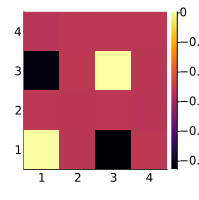

In [118]:
using Plots
rhs = reshape(∇_dot(u), nₓ^3)
@time ϕ_arr, history = cg(Δ_lin, rhs; log=true)
println(history[:resnorm][end])
ϕ = reshape(ϕ_arr, (nₓ, nₓ, nₓ))
heatmap(ϕ[:,:,1], size=(200,200))

In [119]:
println(maximum(abs.(∇_dot(u))))
println(maximum(abs.(∇_dot(u - ∇(ϕ)))))

0.3261758125822468
0.16486789168277222


In [120]:
u_new_arr .= u_arr
u_new = get_views(u_new_arr)
advect_semi_lagrangian!(u_new_arr, Δt);

  0.000031 seconds (12 allocations: 2.953 KiB)


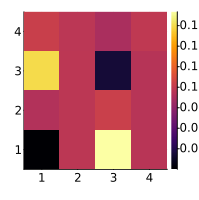

In [121]:
rhs = reshape(∇_dot(u_new), nₓ^3)
@time ϕ_arr = cg(Δ_lin, rhs)
ϕ = reshape(ϕ_arr, (nₓ, nₓ, nₓ))
heatmap(ϕ[:,:,1], size=(200,200))

In [122]:
println(maximum(∇_dot(u_new)))
println(maximum(∇_dot(u_new - ∇(ϕ))))


0.27175815295036604
0.15017024544712756


In [123]:
function step(u_arr, Δt)
    # on staggered grid
    advect_semi_lagrangian!(u_arr, Δt)
    # regrid for this part (for stability)
    # u_reg = stag_to_reg(u_arr)
    # diffuse_backward_Euler!(u_arr, Δt) # numerical diffusion may be enough
    project_incompressible!(u_arr)
    # u_arr = reg_to_stag!(u_arr)
    return u_arr
end

function step_d(r, ψ, u_arr_cache, Δt)
    u_arr = get_tmp(u_arr_cache, r)
    u_arr = step(u_arr + r*ψ, Δt)
end

step_d (generic function with 1 method)

In [137]:
for t in 1:100
    u_arr = step(u_arr, Δt)
end

ErrorException: iteration is deliberately unsupported for CartesianIndex. Use `I` rather than `I...`, or use `Tuple(I)...`

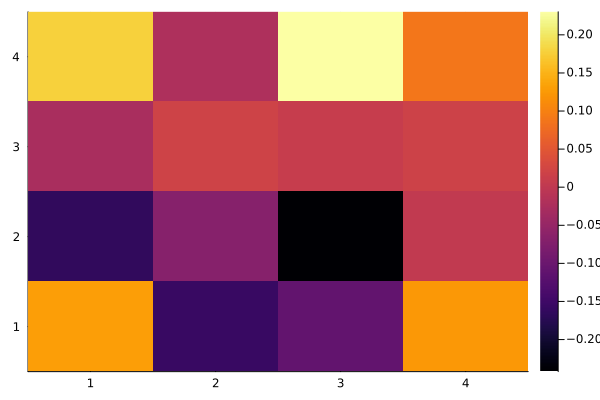

In [125]:
curlz = ∇X(u)[3]
heatmap(curlz[:,:,1])

In [126]:
@time begin
    u_new_arr .= u_arr
    advect_semi_lagrangian!(u_new_arr, Δt)
end

@time begin
    u_new_arr .= u_arr
    project_incompressible!(u_new_arr)
end

  0.001069 seconds (18.31 k allocations: 698.266 KiB)
  0.000117 seconds (55 allocations: 9.672 KiB)


192-element Vector{Float64}:
 -0.10546555057221482
 -0.06776676339344062
  0.027361002369230242
 -0.08491908188578262
 -0.05433292425390896
  0.016945813289177505
  0.06944258565409939
  0.07772413016678724
  0.23590593461467357
  0.05524874673767227
  ⋮
 -0.0157671794989033
  0.04166116724836485
 -0.040022505102924204
 -0.01113447975045272
  0.06279967747235936
  0.00036665218646266505
 -0.009125216179001073
 -0.024513054291379524
  0.025062974426181415